In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.special import expit, logit

In [7]:
#    R|RxR  L|RxR  R|RxL  L|RxL  R|LxL  L|LxL

D = [[841,  115,   113,   54,    1,     7]]  # Ramaley 1913, paper says it does not fit
D = [[6917, 308,   411,   53,    18,    7]]  # Chamberlain 1928 
D = [[1842, 151,   140,   34,    5,     6]]  # Rife 1940
D = [[140,  34,    33,    20,    8,     2]]  # Merrell 1975
D = [[6206, 669,   471,   125,   5,     1]]  # Annett 1973
D = [[154,  11,    31,    9,     0,     0]]  # Ferronato et al. 1947
D = [[232,  17,    41,    7,     3,     1]]  # Mascie-Taylor (unpub, in McManus 1985)
D = [[1060, 144,   122,   46,    3,     4]]  # Chaurasia & Groswani (unpub, in McManus 1985)
D = [[1656, 130,   170,   40,    4,     0]]  # Annett 1978
D = [[303,  37,    45,    15,    0,     0]]  # Carter-Saltzmann 1980
D = [[315,  68,    57,    16,    0,     0]]  # Coren & Porac 1980
D = [[848,  211,   325,   150,   30,    22]] # McGee & Cozad 1980
D = [[58,   9,     14,    5,     0,     0]]  # McManus 1985 ICM1
D = [[134,  15,    17,    9,     1,     0]]  # McManus 1985 ICM2prop
D = [[74,   4,     6,     2,     0,     0]]  # McManus 1985 ICM2mat 
D = [[86,   4,     8,     1,     0,     0]]  # McManus 1985 ICM2pat
D = [[1723, 173,   281,   63,    8,     3]]  # Leiber & Axelrod 1981

D = np.array(D)

In [8]:
def compute_T(ρ, α, β):
    """Generate T - column DD in Table 1
    
    From Appendix 3:    
    T is a 3 x 2 matrix of p(Ht | Ht x Ht) entries - 
    probability of a truly H child from a mating where parents are truly H
    """
    return np.array([
        # R           L
        [0.5 + ρ + α, 1 - (0.5 + ρ + α) ],# RxR
        [0.5 + ρ + β, 1 - (0.5 + ρ + β) ],# RxL
        [0.5 + ρ - α, 1 - (0.5 + ρ - α) ] # LxL
    ])

In [9]:
def compute_t(ρ, α, β):
    """Generate t - eq .3 - the true incidence of left-handedness
    
    From main text:
    F_DR is the final equilibrium frequency of right-handers with allele D fixed
    We need F_DL = 1 - F_DR
    """
    if β == 0:        
        FDR = (1 - 2 * α + 2 * ρ) / (2 * (1 - 2 * α)) # eq 3a
    else:
        Δ = 4 * α * α - 4 * α + 4 * β * β + 1 + 8 * β * ρ
        FDR = (2 * α + 2 * β - 1 + np.sqrt(Δ)) / (4 * β) # eq 3    
    return 1 - FDR

In [10]:
def compute_mp_mo(D, t):    
    mp = (D[2] + D[3] + 2*D[4] + 2*D[5]) / (2*D.sum())
    mo = (D[1] + D[3] + D[5]) / D.sum()
    return mp, mo

In [11]:
def compute_P(mp, t):
    if mp > t:
        u = (mp - t)/mp
        assert 0 < u < 1, u
        P = np.array([
            [1, 0 ,0],
            [u, 1-u, 0],
            [u*u, 2*u*(1-u), (1-u)*(1-u)]
        ])
    else:
        v = (t - mp)/t
        assert 0 < v < 1, (v, mp, t)
        P = np.array([
            [(1-v)*(1-v), 2*v*(1-v), v*v],
            [0, 1-v, v],
            [0, 0, 1]
        ])
    return P

In [12]:
def compute_O(mo, t):
    """Appendix 3"""
    if mo > t:
        w = (mo - t)/mo
        assert 0 < w < 1, w
        O = np.array([
            [1-w, w],
            [0, 1]
        ])
    else:
        x = (t - mo)/t
        assert 0 < x < 1, x
        O = np.array([
            [1, 0], 
            [x, 1-x]
        ])
    return O

In [13]:
def compute_M(T, P, O):    
    M = P @ T @ O
    return M

In [14]:
def log_likelihood(θ, D):    
    D = np.atleast_2d(D)
    ρ, α, β = θ
    S = 0
    
    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0<=T) & (T<=1)).all(), T
    assert 0 < t < 1
    for D_ in D:
        mp, mo = compute_mp_mo(D_, t)
        assert 0 < mp < 1
        assert 0 < mo < 1
        P = compute_P(mp, t)
        assert ((0<=P) & (P<=1)).all()
        O = compute_O(mo, t)
        assert ((0<=O) & (O<=1)).all()
        M = compute_M(T, P, O)
        assert ((0<=M) & (M<=1)).all()
        logM = np.log(M)
        
        S += (
            D_[0] * logM[0,0] + # R|RxR
            D_[1] * logM[0,1] + # L|RxR
            D_[2] * logM[1,0] + # R|RxL
            D_[3] * logM[1,1] + # L|RxL
            D_[4] * logM[2,0] + # R|LxL
            D_[5] * logM[2,1]   # L|LxL
        )
    return S 

In [15]:
θ = np.array([0.267, 0.148, 0.012])
log_likelihood(θ, D)

-786.3970952355701

In [16]:
def log_prior(θ):
    if (θ < 0).any() or (θ>1).any():
        return -np.inf
    ρ, α, β = θ
    T = compute_T(ρ, α, β)
    if not ((0<=T) & (T<=1)).all():
        return -np.inf
    t = compute_t(ρ, α, β)
    if t < 0 or t > 1:
        return -np.inf
    return 0
log_prior(θ)

0

In [17]:
def log_posterior(θ, D):
    logpri = log_prior(θ)
    if np.isinf(logpri):
        return logpri
    return logpri + log_likelihood(θ, D)

log_posterior(θ, D)

-786.3970952355701

# Maximum likelihood

In [18]:
def neg_log_posterior(θ, D):
    return -log_posterior(θ, D)
res = opt.minimize(neg_log_posterior, abs(np.random.normal(0.2, 0.01, size=3)), args=D, method='Nelder-Mead', tol=1e-8)
res.x, -res.fun

(array([0.1883341 , 0.13188227, 0.3116659 ]), -753.5820096402099)

# Bayesian inference

In [19]:
import emcee
import corner

ModuleNotFoundError: No module named 'emcee'

In [20]:
ndim = 3  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 500000 // nwalkers  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

guesses = abs(np.random.normal(0.1, 0.01, size=(nwalkers, ndim)))
assert np.isfinite([log_prior(g) for g in guesses]).all()
assert np.isfinite([log_posterior(g, D) for g in guesses]).all()

In [21]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[D]
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
# discard burn-in points and flatten with ravel()
sample = sampler.chain[:, nburn:, :]

NameError: name 'emcee' is not defined

In [22]:
θ_hat = sample.mean(axis=(0, 1))

print("θ = {}, logL(θ) = {}".format(θ_hat, log_likelihood(θ_hat, D)))

NameError: name 'sample' is not defined

NameError: name 'sampler' is not defined

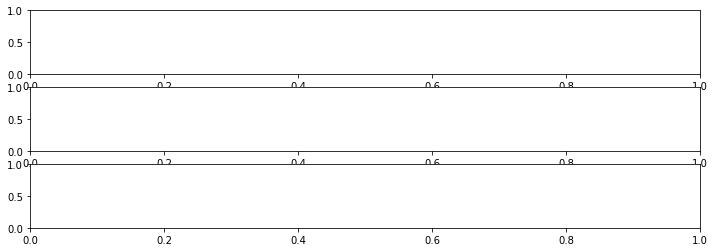

In [23]:
fig, axes = plt.subplots(ndim, 1, figsize=(12, 4))
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    param = θ[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25)
    ax.axhline(sampler.chain[:,:,i].mean(), color='r')
    ax.axvline(nburn, color='b')
    ax.set_ylabel(labels[i])
fig.tight_layout()

In [24]:
θ

array([0.267, 0.148, 0.012])

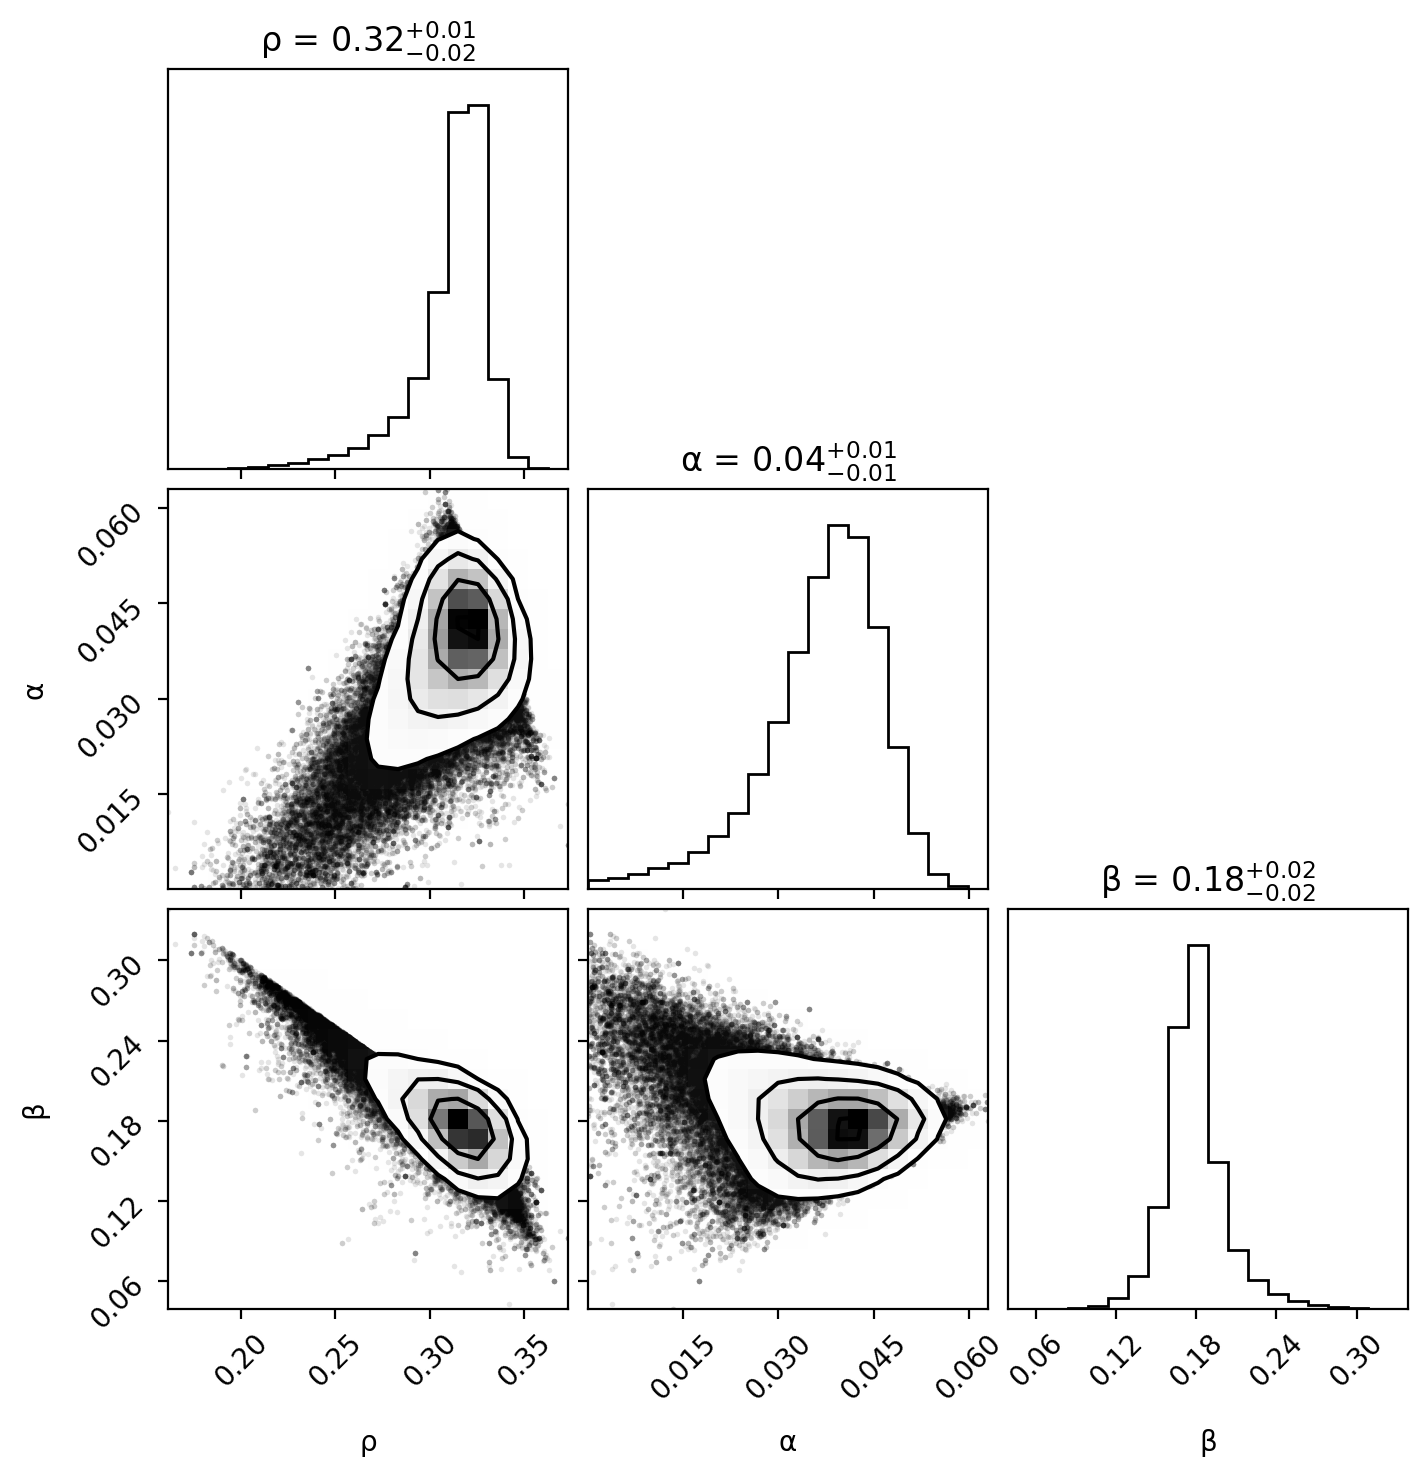

In [64]:
cor = corner.corner(sample.reshape((-1, ndim)), 
    smooth=True,
    labels=labels,
    show_titles=True
)